In [2]:
import pandas as pd


train_data = pd.read_csv("/Users/dhanalakshmijothi/Desktop/Kaggle/titanic/train.csv")
test_data = pd.read_csv("/Users/dhanalakshmijothi/Desktop/Kaggle/titanic/test.csv")

print(train_data.head())
print(test_data.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
              min       max
PassengerId  1.00  891.0000
Survived     0.00    1.0000
Pclass       1.00    3.0000
Age          0.42   80.0000
SibSp        0.00    8.0000
Parch        0.00    6.0000
Fare         0.00  512.3292


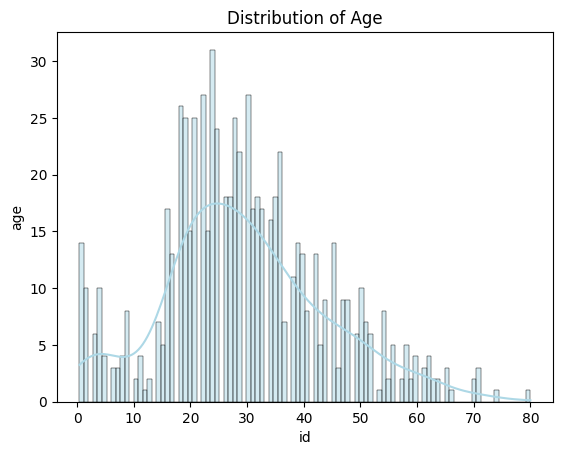

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

missing_values = train_data.isnull().sum()
print(missing_values)

outliers = train_data.describe().loc[['min', 'max']].T
print(outliers)

#missing values in Age, Cabin, Embarked
age = pd.DataFrame({
    'id' : train_data['PassengerId'],
    'age': train_data['Age']
})

#plt.hist(age['age'].dropna(), bins=100, color='lightblue', edgecolor='black', alpha=0.6, label='Histogram')
#sns.kdeplot(age['age'].dropna(), color='red', linewidth=2, label='KDE Curve')

sns.histplot(age['age'].dropna(), bins=100, kde=True, color='lightblue', edgecolor='black')
plt.title("Distribution of Age")
plt.xlabel('id')
plt.ylabel('age')
plt.show()

train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode)
test_data['Embarked'] = test_data['Embarked'].fillna(test_data['Embarked'].mode)

train_data['Cabin_deck'] = train_data['Cabin'].str[0]
test_data['Cabin_deck'] = test_data['Cabin'].str[0]

train_data['Cabin_deck'] = train_data['Cabin_deck'].fillna('U')
test_data['Cabin_deck'] = test_data['Cabin_deck'].fillna('U')
